In [1]:
MAKE_BOOK_FIGURES=True

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        
        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout settings
        'figure.constrained_layout.use': True,
        
        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

# Density Estimation with High-dimensional Data

We are going to create a model that can sample handwritten digits.
To achieve this, we will use PCA to reduce the dimensionality of the MNIST images and then apply Gaussian mixture density estimation on the principal components.
The resulting model will not be perfect, but it very simple and a decent start.
For simplicity, we are going to work only with the threes.

Start by loading the data and extracting the threes:

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X / 255.0

# Split data into train partition and test partition
np.random.seed(12345)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

/opt/homebrew/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Apply PCA to the threes keeping just a few components:

In [3]:
from sklearn.decomposition import PCA

threes = x_train[y_train == '3']
num_components = 2
pca = PCA(
    n_components=num_components,
    whiten=True
).fit(threes)

Now, use the Gaussian mixture model on the principal components.
We are also going to use BIC to figure out what is the correct number of mixture components.

In [4]:
from sklearn.mixture import GaussianMixture

Z = pca.transform(threes)

max_num_components = 11
bics = np.ndarray((max_num_components - 1, ))
models = []
for nmc in range(1, max_num_components):
    m = GaussianMixture(n_components=nmc).fit(Z)
    bics[nmc-1] = m.bic(Z)
    models.append(m)

Here are the BICS:

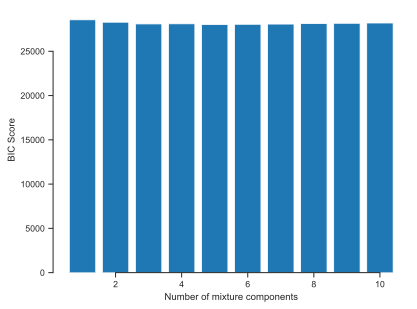

In [9]:
fig, ax = plt.subplots()
ax.bar(range(1, max_num_components), bics)
ax.set_ylabel('BIC Score')
ax.set_xlabel('Number of mixture components')
sns.despine(trim=True);

Let's find the mixture model with the smallest BIC:

In [10]:
model = models[np.argmin(bics)]
print(model)

GaussianMixture(n_components=5)


Now let's sample some random threes...

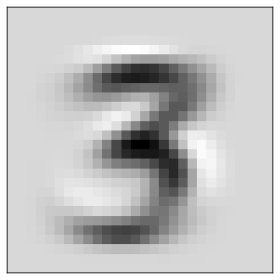

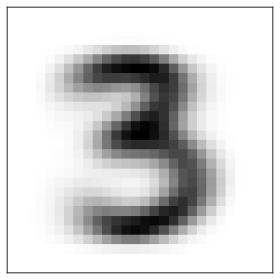

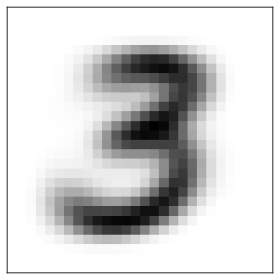

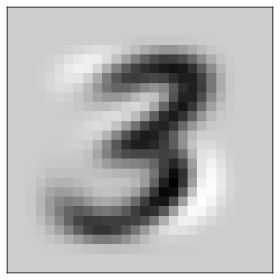

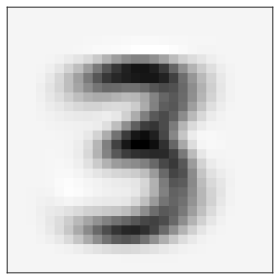

In [11]:
for i in range(5):
    z = model.sample()[0]
    x = pca.inverse_transform(z[None, :])
    show_digit_image(x)

## Questions

+ Try the same code above with ones instead of threes. You just need to modify the code line ``threes = x_train[y_train == 3]`` to ``threes = x_train[y_train == 1]``. Don't bother about renaming the variables.

+ Try increasing the number of PCA components (3, 5, 10, 20). Do the results improve or become worse? What seems to be the problem?